# **PicoScope**: analysis of background

## Preliminary operations

### Paths

In [1]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "data/"
SAVE_PATH = "../../plots/data/picoscope/"

### Flags

In [2]:
UNZIP_DATA    = False
WAVE2NUMPY    = True
PLOT_WAVE     = True
PLOT_MAV_WAVE = True
REJECT_3SIGMA = False
SAVE_DATA     = True
VERBOSE       = True

### Load packages

In [3]:
import os
import sys
import ROOT
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

Welcome to JupyROOT 6.22/06


In [4]:
from ROOT import TF1
from ROOT import TCanvas, TGraph, TGraphErrors

### Settings

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [6]:
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

<ipython-input-6-4c3d034b1475>:1: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


### Constants

In [7]:
PATIENCE = 1000
MIN_MV   = 2000
MAX_MV   = 3300

In [8]:
bkg_dirs = [
    "bkg_50h_271120",
    "bkg_24h_151220"
]

### Functions

In [9]:
def moving_average(x, M):
    return np.convolve(x, np.ones(M), 'valid') / M

## Convert waveform files to numpy array and store

### Unzip all data archives and get number of events

In [10]:
if UNZIP_DATA:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        if d in bkg_dirs:
            os.chdir(d)

            if VERBOSE:
                print(d)

            if not os.path.exists("data"):
                os.system("unzip data.zip -d data")
            
            os.chdir("../")

### Convert to numpy array

In [11]:
if WAVE2NUMPY:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        if d in bkg_dirs:
            os.chdir(d)

            if VERBOSE:
                print("Processing:", d)

            if not os.path.exists(d+".npy"):
                N = len(os.listdir("./data"))
                M = 5000

                data = np.zeros((N,M),dtype=np.int16)
                for f,i in zip(os.listdir("./data"), range(N)):
                    if (i % PATIENCE == 0) and VERBOSE:
                        sys.stdout.write("\r    Completeness : "+str(round(i/N*100,1))+"%")

                    data[i,:] = np.loadtxt("./data/" + f)
                np.save(d+".npy", data)
                os.system("rm -rf ./data")

            if VERBOSE:
                sys.stdout.write("\n")

            os.chdir("../")

Processing: bkg_50h_271120

Processing: bkg_24h_151220



## Analysis

In [12]:
M  = 20    # moving average (MAV) filter M
SC = 33    # picoscoper center in steps

### Collect data angle

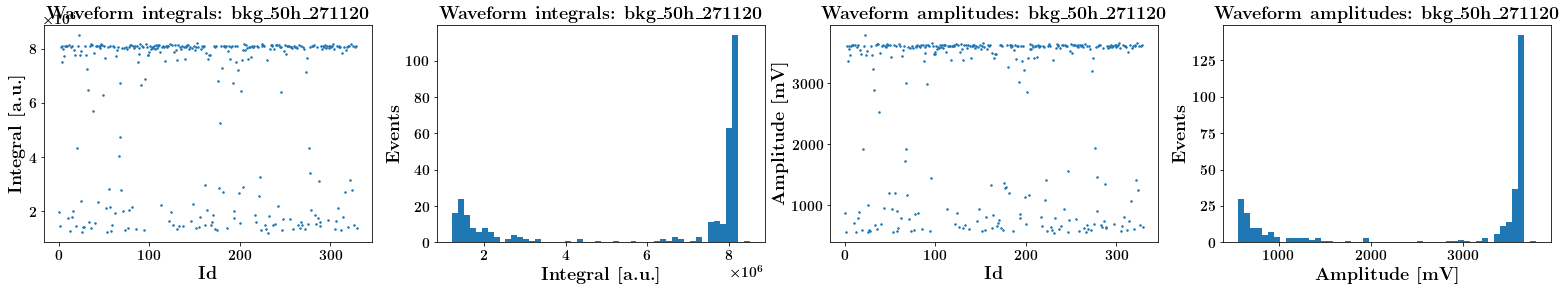

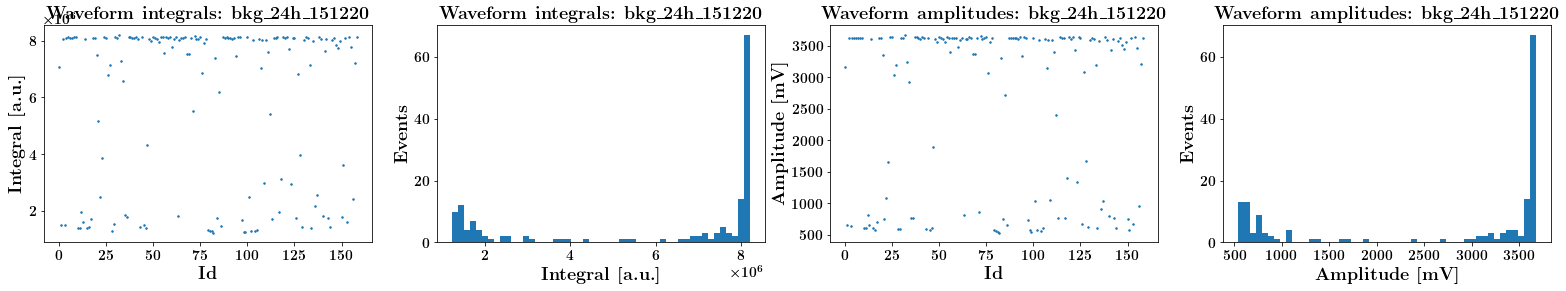

In [13]:
angles = []
events = []
err_angles = []
err_events = []

pico_step = []
pico_rad  = []
pico_deg  = []
pico_seg  = []
pico_ev   = []
pico_t    = []
pico_r    = []

pico_step_err = []
pico_rad_err  = []
pico_deg_err  = []
pico_ev_err   = []
pico_r_err    = []



os.chdir(DATA_PATH)
for d in os.listdir("."):
    if d in bkg_dirs:
        os.chdir(d)

        #######################################################################
        # TAKE DATA FROM run FILE
        #######################################################################
        file = open("run")
        line = file.readlines()
        for l in line:
            if (l.startswith("n_segments")):
                n_seg = int(l.split('=')[1].strip())
                pico_seg.append(n_seg)
            if (l.startswith("run_time")):
                run_time = int(l.split('=')[1].strip())
        file.close()
        #######################################################################
    
        #######################################################################
        # TAKE DATA FROM run_BlockTimes.txt
        #######################################################################
        times  = np.loadtxt("run_BlockTimes.txt")
        blocks = times.shape[0]
        events = blocks * n_seg
        # print(times.shape)
        if times.shape != (2,):
            t  = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])
        else:
            t  = run_time
        #######################################################################

    
        #######################################################################
        # TAKE DATA FROM ALL WAVEFORMS
        #######################################################################
        if WAVE2NUMPY:
            # load data and smooth filter with MAV
            data     = np.load(d+".npy")
            data_mav = np.apply_along_axis(moving_average, 1, data, M)

            # compute baseline mask
            baseline_mask = np.arange(data_mav.shape[1])
            baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

            # compute baseline and amplitude
            baseline   = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]
            peaks      = np.max(data_mav, axis=1)
            amplitudes = (peaks - baseline) * 10 / 65536 * 1000

            # filter events by waveform amplitude
            events = amplitudes[(amplitudes>=MIN_MV) & (amplitudes<=MAX_MV)].shape[0]

            # compute integral
            data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]

            # compute integral mean and variance
            data_mav_int_mean = np.mean(data_mav_int)
            data_mav_int_var  = np.std(data_mav_int)

            # not so useful (it will be removed)
            if REJECT_3SIGMA:
                mask_t = np.logical_and(data_mav_int<data_mav_int_mean+data_mav_int_var*3, data_mav_int>data_mav_int_mean-data_mav_int_var*3)
                mask_f = np.logical_not(mask_t)
            else:
                mask_t = np.ones(data_mav_int.shape, dtype=bool)
                mask_f = np.logical_not(mask_t)

            if PLOT_WAVE:
                fig=plt.figure(figsize=(6*4+3, 4))
                plt.subplot(1,4,1)
                if mask_f.shape[0] != 0:
                    plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
                    plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)
                else:
                    plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
                plt.xlabel(r"\bf{Id}")
                plt.ylabel(r"\bf{Integral [a.u.]}")
                plt.title(r"\bf{Waveform integrals: " + str(d.replace("_", "\_")) + "}")

                plt.subplot(1,4,2)
                if mask_f.shape[0] != 0:
                    plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
                else:
                    plt.hist(data_mav_int[mask_t], bins=50, stacked=True)
                # plt.yscale("log")
                plt.xlabel(r"\bf{Integral [a.u.]}")
                plt.ylabel(r"\bf{Events}")
                plt.title(r"\bf{Waveform integrals: " + str(d.replace("_", "\_")) + "}")

                plt.subplot(1,4,3)
                plt.plot(np.arange(0,amplitudes.shape[0]), amplitudes, "o", markersize=1.5)
                plt.xlabel(r"\bf{Id}")
                plt.ylabel(r"\bf{Amplitude [mV]}")
                plt.title(r"\bf{Waveform amplitudes: " + str(d.replace("_", "\_")) + "}")

                plt.subplot(1,4,4)
                plt.hist(amplitudes, bins=50)
                # plt.yscale("log")
                plt.xlabel(r"\bf{Amplitude [mV]}")
                plt.ylabel(r"\bf{Events}")
                plt.title(r"\bf{Waveform amplitudes: " + str(d.replace("_", "\_")) + "}")
                plt.show()
        #######################################################################


        #######################################################################
        # COMPUTE RELEVANT QUANTITIES
        #######################################################################
        pico_t.append(t)
        pico_ev.append(events)
        pico_r.append(events / t * 3600)
        #######################################################################

        #######################################################################
        # COMPUTE ERRORS
        #######################################################################
        pico_ev_err  .append(np.sqrt(events))
        pico_r_err   .append(np.sqrt(events) / t * 3600)
        #######################################################################

        os.chdir(DATA_PATH)

In [14]:
bkg_r = sum(pico_ev) / sum(pico_t) * 3600 #([evs/ts*3600 for evs,ts in zip(pico_ev,pico_t)])

In [15]:
[evs/ts*3600 for evs,ts in zip(pico_ev,pico_t)]

[0.19961739998283742, 0.49103609069795]

In [16]:
bkg_r

0.2951674822029528